In [1]:
import os
from collections import OrderedDict

import PIL
import importlib
import numpy as np
import pickle
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from skimage.io import imread
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

from settings.paths import LFW_PAIRS_6000, \
                           LFW_FUNNELED_DIR, \
                           LIGHT_CNN_9_WEIGHT, \
                           SRGAN_MSE_LOSS_WEIGHTS_DIR, \
                           SRGAN_VGG_LOSS_3_1_GENERATOR_WEIGHTS_DIR, \
                           SRGAN_VGG_LOSS_3_1_NO_ADVERSARIAL_WEIGHTS_DIR, \
                           SRGAN_LIGHT_CNN_LOSS_MFM4_GENERATOR_WEIGHTS_DIR, \
                           ROC_AUC_DIR
                
from src.light_cnn import LightCNN_9Layers
from src.srgan import Generator

plt.style.use('ggplot')

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '6, 7'

In [3]:
def init_model(name='LightCNN_9', cuda=True):
    if name is 'LightCNN_9':
        model_class = LightCNN_9Layers
        num_classes=79077
    else:
        raise ValueError('No such model {}'.format(name))
        
    model = model_class(num_classes=num_classes)
    model.eval()
    
    if cuda:
        model = torch.nn.DataParallel(model).cuda()
    
    return model

In [4]:
def load_weights(model, weight_path):
    checkpoint = torch.load(weight_path)
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [5]:
model = init_model('LightCNN_9', cuda=True)
model = load_weights(model, LIGHT_CNN_9_WEIGHT)

In [6]:
class LFWFunneled6000Pairs(Dataset):
    def __init__(self, lfw_funneled_dir, pairs_file, additional_transform=None):
        self._lfw_funneled_dir = lfw_funneled_dir
        self._pairs = open(pairs_file).read().split('\n')
        
        transforms_list = [
            transforms.ToPILImage(),
            transforms.CenterCrop(128),
        ]
        if additional_transform is not None:
            transforms_list.extend(additional_transform)
        transforms_list.append(transforms.ToTensor())
        
        self._transforms = transforms.Compose(transforms_list)
        
    def _make_filepath(self, name, number):
        image_name ='{}_{:04d}.jpg'.format(name, int(number))
        return os.path.join(self._lfw_funneled_dir, name, image_name)
        
    def __getitem__(self, index):
        pair = self._pairs[index + 1].split('\t')
        if len(pair) == 3:
            label = 1
            name, number_1, number_2 = pair

            image_path_1 = self._make_filepath(name, number_1)
            image_path_2 = self._make_filepath(name, number_2)
        elif len(pair) == 4:
            label = 0
            name_1, number_1, name_2, number_2 = pair

            image_path_1 = self._make_filepath(name_1, number_1)
            image_path_2 = self._make_filepath(name_2, number_2)

        return self._transforms(imread(image_path_1)), \
               self._transforms(imread(image_path_2)), \
               label

    def __len__(self):
        return 6000


In [7]:
def calculate_roc_auc(lwf_loader, embeddings_model, upscale_model=None, desc=''):
    post_transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ]
    )
    
    labels = []
    thresholds = []
    
    for image_batch_1, image_batch_2, current_labels in tqdm(lwf_loader, desc=desc):
        if upscale_model is not None:
            image_variable_1 = upscale_model(Variable(image_batch_1, volatile=True).cuda())
            image_variable_2 = upscale_model(Variable(image_batch_2, volatile=True).cuda())
            image_batch_1 = image_variable_1.data.cpu()
            image_batch_2 = image_variable_2.data.cpu()
        
        image_grayscale_1 = []
        image_grayscale_2 = []
        for image_num in range(image_batch_1.size()[0]):
            image_grayscale_1.append(post_transform(image_batch_1[image_num]))
            image_grayscale_2.append(post_transform(image_batch_2[image_num]))
            
        image_grayscale_1 = torch.stack(image_grayscale_1)
        image_grayscale_2 = torch.stack(image_grayscale_2)
        
        _, features_1 = embeddings_model(Variable(image_grayscale_1, volatile=True).cuda())
        _, features_2 = embeddings_model(Variable(image_grayscale_2, volatile=True).cuda())
        
        current_thresholds = -torch.mean((features_1 - features_2) ** 2, dim=-1)
        
        thresholds.extend(current_thresholds.data.cpu().numpy())
        labels.extend(current_labels)
        
    return roc_auc_score(labels, thresholds)

In [8]:
roc_auc_scores = OrderedDict()

## HR

In [9]:
lwf_dataset_hr = LFWFunneled6000Pairs(LFW_FUNNELED_DIR, LFW_PAIRS_6000)
lwf_loader_hr = DataLoader(
    dataset=lwf_dataset_hr,
    batch_size=16,
    num_workers=4,
    shuffle=False
)

roc_auc_hr = calculate_roc_auc(lwf_loader_hr, model)

100%|██████████| 375/375 [00:33<00:00, 11.27it/s]


In [10]:
roc_auc_hr

0.9820735555555555

In [11]:
roc_auc_scores['HR'] = roc_auc_hr

## Bicubic interpolation

In [12]:
down_up_bicubic = [
    transforms.Resize(32, PIL.Image.NEAREST),
    transforms.Resize(128, PIL.Image.BICUBIC),
]

lwf_dataset_hr = LFWFunneled6000Pairs(LFW_FUNNELED_DIR, LFW_PAIRS_6000, additional_transform=down_up_bicubic)
lwf_loader_hr = DataLoader(
    dataset=lwf_dataset_hr,
    batch_size=16,
    num_workers=4,
    shuffle=False
)

roc_auc_bicubic = calculate_roc_auc(lwf_loader_hr, model)

100%|██████████| 375/375 [00:40<00:00,  9.74it/s]


In [13]:
roc_auc_bicubic

0.9355899999999998

In [14]:
roc_auc_scores['Bicubic'] = roc_auc_bicubic

## SRGAN MSE

In [15]:
def plot_checkpoints_roc_auc(roc_auc_list,
                             step_list,
                             name,
                             lines=roc_auc_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(step_list, roc_auc_list, c='r')
    plt.ylabel('ROC AUC')
    plt.xlabel('Step')
    plt.title(name)
    plt.xticks(rotation=45)
    
    drawn_list = []
    for num, ((line_name, value), color) in enumerate(
        zip(lines.items(), ['b', 'm', 'g', 'c', 'y', 'k', 'w'])
    ):
        linestyle='-'
        for drawn_value in drawn_list:
            if np.abs(drawn_value - value) < 0.001:
                linestyle = '--'
                break
            
        plt.axhline(
            y=value,
            color=color, linestyle=linestyle,
            zorder=num,
            label=line_name, lw=2
        )
        drawn_list.append(value)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

In [16]:
def roc_auc_for_all_checkpoints(name, embeddings_model, upscale_model, weight_directory, lwf_loader_hr,
                                continue_auc_and_files=None):
    def analyse():
        clear_output()
        cur_max_roc_auc_arg = np.argmax(roc_auc_list)
        print('Max ROC AUC is {} on {} step'.format(
            roc_auc_list[cur_max_roc_auc_arg], current_files_list[cur_max_roc_auc_arg]
        ))
        plot_checkpoints_roc_auc(roc_auc_list, current_files_list, name)
        
        return cur_max_roc_auc_arg
    
    files = sorted(os.listdir(weight_directory))
    downscale = [
        transforms.Resize(32, PIL.Image.NEAREST),
    ]
    
    if continue_auc_and_files is not None:
        roc_auc_list, current_files_list = continue_auc_and_files
    else:
        roc_auc_list, current_files_list = [], []
    
    if len(files) > 0:
        last_checkpoint_file_num = os.path.splitext(files[-1])[0]

        for file in files:
            checkpoint_file_num = os.path.splitext(file)[0]
            if checkpoint_file_num in current_files_list:
                continue

            checkpoint_file = os.path.join(weight_directory, file)

            upscale_model.load_state_dict(torch.load(checkpoint_file))

            loading_desc = '{}/{}'.format(checkpoint_file_num, last_checkpoint_file_num)
            roc_auc_list.append(
                calculate_roc_auc(lwf_loader_hr, embeddings_model, upscale_model, loading_desc)
            )
            current_files_list.append(checkpoint_file_num)
            cur_max_roc_auc_arg = analyse() 
    else:
        roc_auc_list, current_files_list, cur_max_roc_auc_arg = [1], [0], 0

    cur_max_roc_auc_arg = analyse()
    
    return roc_auc_list, current_files_list, cur_max_roc_auc_arg

In [17]:
def make_save_path(save_dir, name):
    return os.path.join(save_dir, name.lower().replace(' ', '_'))

def save_roc_auc(name, roc_auc_list, files_list, save_dir=ROC_AUC_DIR):
    save_path = make_save_path(save_dir, name)
    with open(save_path, 'wb') as file:
        pickle.dump((roc_auc_list, files_list), file)
        
def load_roc_auc(name, save_dir=ROC_AUC_DIR):
    load_path = make_save_path(save_dir, name)
    with open(load_path, 'rb') as file:
        roc_auc_list, files_list = pickle.load(file)
    return roc_auc_list, files_list

In [18]:
n_resblocks=16
n_upsample=2
generator = Generator(n_resblocks, n_upsample)
generator = nn.DataParallel(generator).cuda()

In [19]:
downscale = [
    transforms.Resize(32, 0),
]

lwf_dataset_hr = LFWFunneled6000Pairs(LFW_FUNNELED_DIR, LFW_PAIRS_6000, additional_transform=downscale)
lwf_loader_hr = DataLoader(
    dataset=lwf_dataset_hr,
    batch_size=16,
    num_workers=4,
    shuffle=False
)

Max ROC AUC is 0.9596294444444444 on 0000601682 step


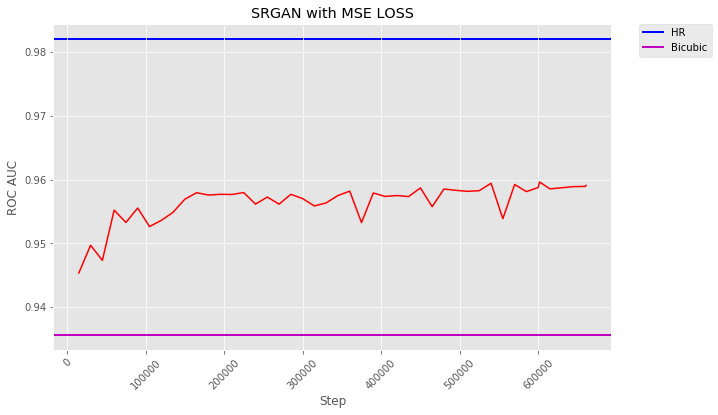

In [20]:
experiment_name = 'SRGAN with MSE LOSS'
roc_auc_list_mse, files_list_mse, max_roc_auc_arg_mse = roc_auc_for_all_checkpoints(
    experiment_name, model, upscale_model=generator,
    weight_directory=SRGAN_MSE_LOSS_WEIGHTS_DIR,
    lwf_loader_hr=lwf_loader_hr,
    continue_auc_and_files=load_roc_auc('MSE Loss')
)
save_roc_auc('MSE Loss', roc_auc_list_mse, files_list_mse)

In [21]:
roc_auc_list_mse[max_roc_auc_arg_mse], files_list_mse[max_roc_auc_arg_mse]

(0.9596294444444444, '0000601682')

In [22]:
roc_auc_scores['MSE Loss'] = roc_auc_list_mse[max_roc_auc_arg_mse]

## SRGAN VGG (3.1)

Max ROC AUC is 0.9637131666666666 on 0000450000 step


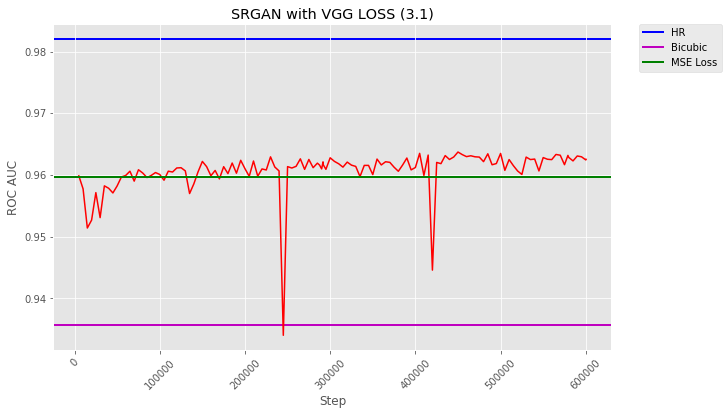

In [50]:
experiment_name = 'SRGAN with VGG LOSS (3.1)'
roc_auc_list_vgg, files_list_vgg, max_roc_auc_arg_vgg = roc_auc_for_all_checkpoints(
    experiment_name, model, upscale_model=generator,
    weight_directory=SRGAN_VGG_LOSS_3_1_GENERATOR_WEIGHTS_DIR,
    lwf_loader_hr=lwf_loader_hr,
    continue_auc_and_files=load_roc_auc('VGG Loss 3.1')
)
save_roc_auc('VGG Loss 3.1', roc_auc_list_vgg, files_list_vgg)

In [51]:
roc_auc_list_vgg[max_roc_auc_arg_vgg], files_list_vgg[max_roc_auc_arg_vgg]

(0.9637131666666666, '0000450000')

In [52]:
roc_auc_scores['VGG Loss 3.1'] = roc_auc_list_vgg[max_roc_auc_arg_vgg]

## SRGAN LIGHT CNN (MFM4)

Max ROC AUC is 0.9596534444444446 on 0000170000 step


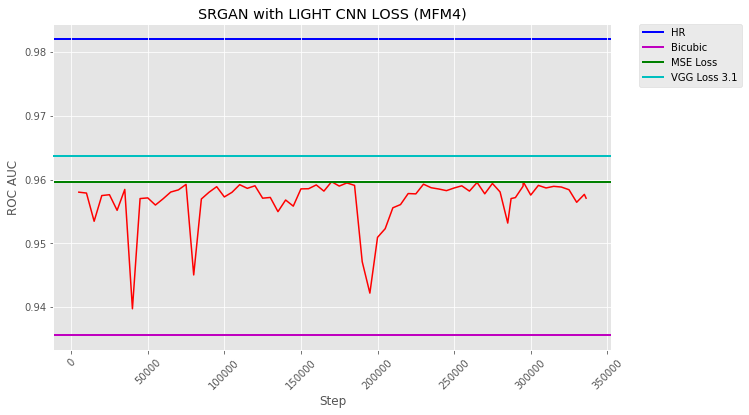

In [73]:
experiment_name = 'SRGAN with LIGHT CNN LOSS (MFM4)'
roc_auc_list_light_cnn, files_list_light_cnn, max_roc_auc_arg_light_cnn = roc_auc_for_all_checkpoints(
    experiment_name, model, upscale_model=generator,
    weight_directory=SRGAN_LIGHT_CNN_LOSS_MFM4_GENERATOR_WEIGHTS_DIR,
    lwf_loader_hr=lwf_loader_hr,
    continue_auc_and_files=load_roc_auc('LIGHT CNN Loss MFM4')
)
save_roc_auc('LIGHT CNN Loss MFM4', roc_auc_list_light_cnn, files_list_light_cnn)

In [74]:
roc_auc_list_light_cnn[max_roc_auc_arg_light_cnn], files_list_light_cnn[max_roc_auc_arg_light_cnn]

(0.9596534444444446, '0000170000')

In [75]:
roc_auc_scores['LIGHT CNN Loss MFM4'] = roc_auc_list_light_cnn[max_roc_auc_arg_light_cnn]

## SRGAN VGG (3.1) NO ADVERSARIAL

Max ROC AUC is 0.9635957777777779 on 0000570000 step


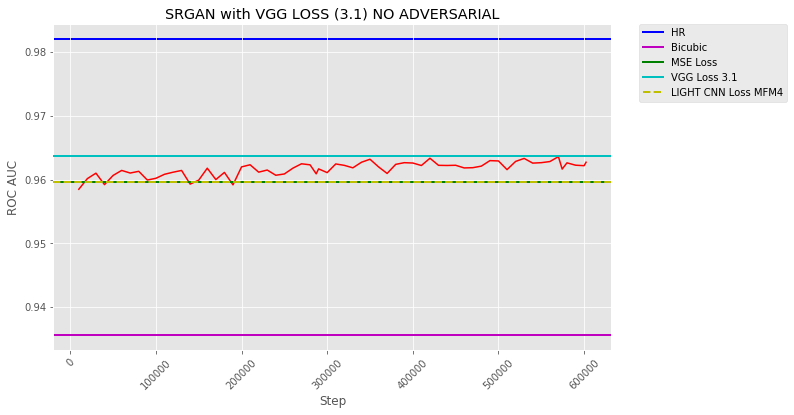

In [76]:
experiment_name = 'SRGAN with VGG LOSS (3.1) NO ADVERSARIAL'
roc_auc_list_vgg_no_adv, files_list_vgg_no_adv, max_roc_auc_arg_vgg_no_adv = roc_auc_for_all_checkpoints(
    experiment_name, model, upscale_model=generator,
    weight_directory=SRGAN_VGG_LOSS_3_1_NO_ADVERSARIAL_WEIGHTS_DIR,
    lwf_loader_hr=lwf_loader_hr,
    continue_auc_and_files=load_roc_auc('VGG Loss 3.1 no adversarial')
)
save_roc_auc('VGG Loss 3.1 no adversarial', roc_auc_list_vgg_no_adv, files_list_vgg_no_adv)

In [77]:
roc_auc_list_vgg_no_adv[max_roc_auc_arg_vgg_no_adv], files_list_vgg_no_adv[max_roc_auc_arg_vgg_no_adv]

(0.9635957777777779, '0000570000')

In [ ]:
# roc_auc_scores['VGG Loss 3.1 no adversarial'] = roc_auc_list_vgg_no_adv[max_roc_auc_arg_vgg_no_adv]